## Load and playing back recorded experiments

This tutorial shows how to use the [RecordedExperiment](../reference/sim/python/recorded_experiment.html#navground.sim.RecordedExperiment)
class to load, inspect and play-back a recorded experiment. 

We start by recording one run of the same simple experiment as we did during the [tour](tour.html).

In [1]:
from navground import sim

yaml = """
time_step: 0.1
steps: 300
runs: 1
scenario:
    obstacles:
        - position: [5, 0.1]
          radius: 1.0
    groups:
        - number: 1
          type: thymio
          behavior:
            type: ORCA
          kinematics:
            type: 2WDiff
            wheel_axis: 2
            max_speed: 1
          task:
            type: Waypoints
            loop: true
            tolerance: 0.1
            waypoints: [[10, 0], [0, 0]]
          state_estimation:
            type: Bounded
            range: 5
          position: [0, 0]
          orientation: 0
          radius: 1.0
          control_period: 0.1        
"""

experiment = sim.load_experiment(yaml)

We record all possible data

In [2]:
experiment.record_config.set_all(True)

to an HDF5 file, without saving the data in-memory

In [3]:
path = "recorded_experiment.h5"
experiment.run(keep=False, data_path=path)

We mimic closing the sessing.

In [4]:
del experiment

We can load the HDF5 file directly, like showcased in [this tutorial](running_an_experiment.html), or, like we will do here, we can make use of the [RecordedExperiment](../reference/sim/python/recorded_experiment.html#navground.sim.RecordedExperiment) helper class.

We use the command line to similarly replay the record in a separate HTML view.
```
replay <HDF5_file>
```

In [5]:
from navground import sim
path = "recorded_experiment.h5"

In [6]:
recorded_experiment = sim.RecordedExperiment(path)

which exposes the a readonly version of the [Experiment](../reference/sim/python/experiment.html#navground.sim.Experiment) interface.

For instance, we can load the path followed by the agent

In [7]:
run = recorded_experiment.runs[0]
ps = run.poses
ps.shape

(300, 1, 3)

to plot it

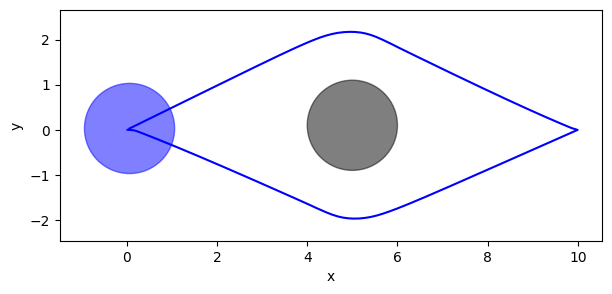

In [8]:
from matplotlib import pyplot as plt

radius = run.world.agents[0].radius

fig, ax = plt.subplots(figsize=((7, 3)))
for obstacle in run.world.obstacles:
    disc = obstacle.disc
    ax.add_patch(plt.Circle(disc.position, disc.radius, color='k', alpha=0.5))
for i in range(ps.shape[1]):
    ax.plot(ps[:, i, 0], ps[:, i, 1], 'b-')
    ax.add_patch(plt.Circle(ps[-1, i], radius, color='b', alpha=0.5))
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.axis('equal');

Let's display a video of the recorded run

In [9]:
from navground.sim.ui.video import display_video_from_run

display_video_from_run(run)

We can also play back the recorded simulation and display it live.

In [10]:
from navground.sim.ui import WebUI
from navground.sim.notebook import notebook_view
from navground.sim.replay import RealTimeReplay

web_ui = WebUI(host='127.0.0.1', max_rate=-1)
await web_ui.prepare()

notebook_view(width=250)

In [11]:
rt_sim = RealTimeReplay(run=run, factor=5, web_ui=web_ui)
await rt_sim.run()

We can also jump to a step. Let's go to when the agents is nearest to the obstacles:

In [12]:
import numpy as np

p = run.world.obstacles[0].disc.position
step = np.argmin(np.linalg.norm(ps[:, 0, :2] - p, axis=1))
run.go_to_step(step)
await rt_sim.update()

The view will then display an image similar to

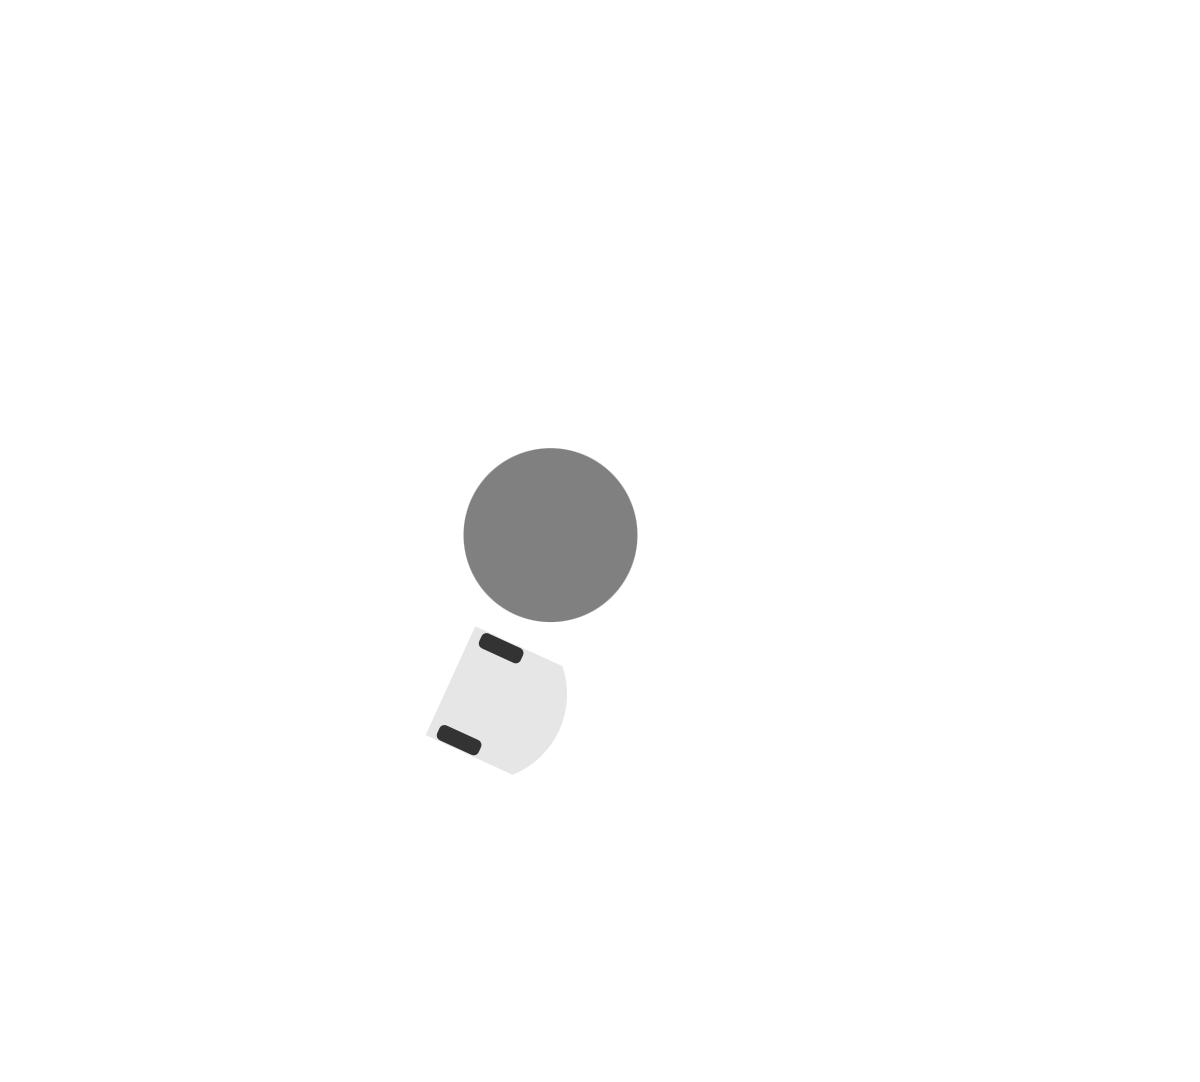

In [13]:
from IPython.display import Image
Image(filename='playback.png', width=250) 

We could also do something more interesting, like changing some parameters and executing a new simulation to compare the resulting trajectories.

For instance, let us increase the safety margin of the agent

In [14]:
agent = run.world.agents[0]
agent.behavior.safety_margin = 0.25

Then we perform a simulation until the end of the run, recording the new trajectory

In [15]:
new_ps = []

while run.world.step < run.recorded_steps:
    run.world.update(time_step=run.time_step)
    new_ps.append(np.array(agent.pose.position))

new_ps = np.asarray(new_ps)

We plot in blue the original recorded trajecotory (with safery margin 0) 
and in red the new portion of trajecotry (with safety margin 0.25)

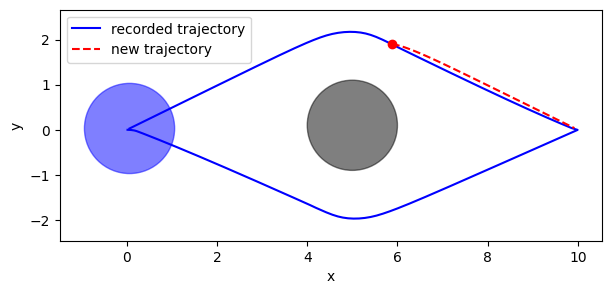

In [16]:
fig, ax = plt.subplots(figsize=((7, 3)))
for obstacle in run.world.obstacles:
    disc = obstacle.disc
    ax.add_patch(plt.Circle(disc.position, disc.radius, color='k', alpha=0.5))
ax.plot(ps[:, 0, 0], ps[:, 0, 1], 'b-', label='recorded trajectory')
ax.plot(new_ps[:1, 0], new_ps[:1, 1], 'ro')
ax.plot(new_ps[:, 0], new_ps[:, 1], 'r--', label='new trajectory')
ax.add_patch(plt.Circle(ps[-1, i], radius, color='b', alpha=0.5))

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()
plt.axis('equal');